# Plots of the 2 meter surface air temperature (SAT)

By: Ty Janoski
Updated: 11.15.21

## Set-up

In [13]:
# import statements:
import xarray as xr
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from dask.diagnostics import ProgressBar

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
# read in cell area file for taking spatial averages
areacella = xr.open_dataarray('/dx01/janoski/cesm/output/gridarea.nc')

In [3]:
# create function for taking spatial averages, while weighting for latitude
def spav(ds_in, areacella=areacella, lat_bound_s = -91, lat_bound_n = 91):
    """
    Use xarray/numpy to calculate spatial average while weighting for latitude.
    
    Keyword arguments:
    ds_in -- Dataset or DataArray to take the average of with coords lat and lon
    areacella -- Dataset or DataArray containing the grid cell area with coords lat and lon
    lat_bound_s -- float, Southern boundary of area to average
    lat_bound_n -- float, Northern boundary of area to average
    """
    ds_in = ds_in.sel(lat=slice(lat_bound_s,lat_bound_n))
    areacella = areacella.sel(lat=slice(lat_bound_s,lat_bound_n))
    out = (ds_in*(areacella/areacella.sum(dim=['lat','lon']))).sum(dim=['lat','lon'])
    return(out)

In [4]:
# create function to preprocess data by overwriting time axes
def preprocess(ds):
    """
    Overwrite time coordinate on xarray datasets being loaded in so that they can be merged.
    
    ds -- dataset or dataarray being opened
    """
    dsnew = ds.copy()
    dsnew['time'] = np.arange(1,731,1)
    return dsnew

In [10]:
plt.gcf().canvas.get_supported_filetypes()


{'eps': 'Encapsulated Postscript',
 'jpg': 'Joint Photographic Experts Group',
 'jpeg': 'Joint Photographic Experts Group',
 'pdf': 'Portable Document Format',
 'pgf': 'PGF code for LaTeX',
 'png': 'Portable Network Graphics',
 'ps': 'Postscript',
 'raw': 'Raw RGBA bitmap',
 'rgba': 'Raw RGBA bitmap',
 'svg': 'Scalable Vector Graphics',
 'svgz': 'Scalable Vector Graphics',
 'tif': 'Tagged Image File Format',
 'tiff': 'Tagged Image File Format'}

<Figure size 432x288 with 0 Axes>

## Data and calculations

In [5]:
# read in CESM-LE datasets and take difference
lead='/dx01/janoski/cesm/output/b40.1850.cam5-lens.'
ctrl_jan = xr.open_mfdataset(lead+'ctrl.01.*TREFHT.nc',preprocess=preprocess,
                             combine='nested', concat_dim='ens',parallel=True).TREFHT
exp_jan = xr.open_mfdataset(lead+'4xCO2.01.*TREFHT.nc',preprocess=preprocess,
                             combine='nested', concat_dim='ens',parallel=True).TREFHT

diff_jan = exp_jan - ctrl_jan

# repeat for july
ctrl_jul = xr.open_mfdataset(lead+'ctrl.07.*TREFHT.nc',preprocess=preprocess,
                             combine='nested', concat_dim='ens',parallel=True).TREFHT
exp_jul = xr.open_mfdataset(lead+'4xCO2.07.*TREFHT.nc',preprocess=preprocess,
                             combine='nested', concat_dim='ens',parallel=True).TREFHT
diff_jul = exp_jul - ctrl_jul

In [6]:
# spatially average the differences
with ProgressBar():
    diff_jan_arc = spav(diff_jan,lat_bound_s=70).compute()
    diff_jan_glb = spav(diff_jan).compute()
    diff_jul_arc = spav(diff_jul,lat_bound_s=70).compute()
    diff_jul_glb = spav(diff_jul).compute()
    
# get t and p vals using 2 sample Welch's t-test
# note: one of the assumptions is that the samples are independent, which isn't strictly true
# because the Arctic area is part of the global average, but it makes up only 6% of the 
# Earth's surface area, so I do not feel like this is too large an issue

t_jan,p_jan = stats.ttest_ind(diff_jan_arc,diff_jan_glb,axis=0,equal_var=False,nan_policy='raise')
t_jul,p_jul = stats.ttest_ind(diff_jul_arc,diff_jul_glb,axis=0,equal_var=False,nan_policy='raise')

[########################################] | 100% Completed |  3min 35.7s
[########################################] | 100% Completed |  1min 18.7s
[########################################] | 100% Completed |  1min 50.1s
[########################################] | 100% Completed | 35.1s


In [7]:
# instead of spatially averaging, let's try making a hovmuller diagram of the change in temp vs lat and time
with ProgressBar():
    diff_jan_zonal = diff_jan.mean(dim='lon').compute()
    diff_jul_zonal = diff_jul.mean(dim='lon').compute()

[########################################] | 100% Completed | 57.8s
[########################################] | 100% Completed | 29.4s


## Plotting

In [8]:
# Get some variables for relabeling the x-axes
first_days_jan = np.array([1,91,182,274])

x_vals_jan = np.concatenate((first_days_jan,first_days_jan+365))
x_labs_jan = np.tile(['Jan 1','Apr 1','Jul 1','Oct 1'],
                 (2))

first_days_jul = np.array([1,92,184,274])
x_vals_jul = np.concatenate((first_days_jul,first_days_jul+365))
x_labs_jul = np.tile(['Jul 1','Oct 1','Jan 1','Apr 1'],
                 (2))

xs=np.arange(1,731,1)

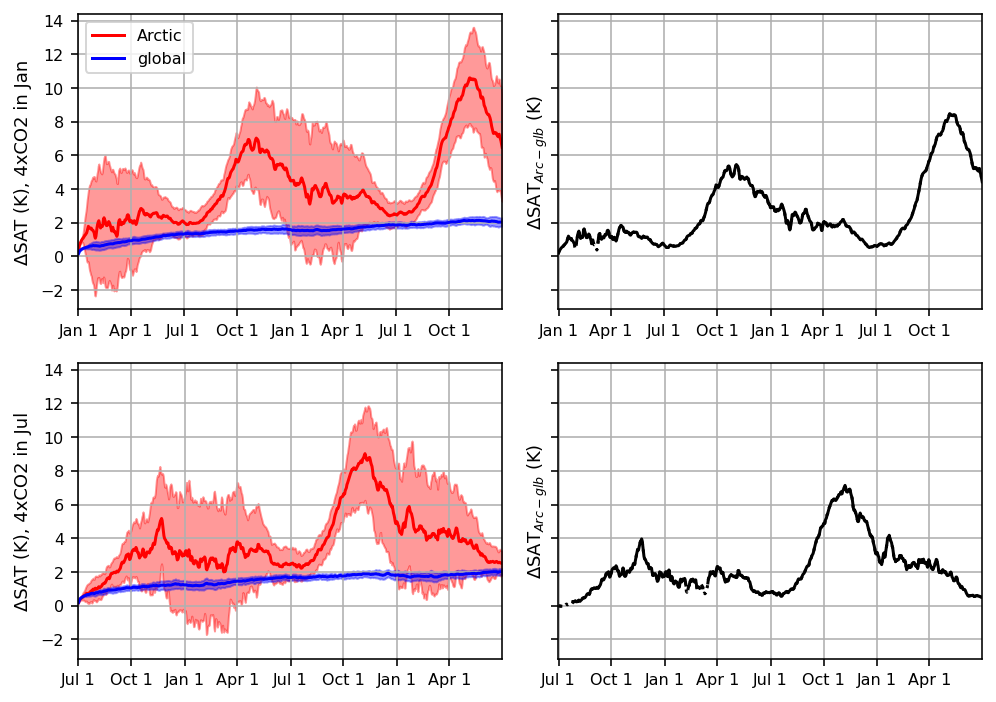

In [14]:
fig, axes = plt.subplots(ncols=2,nrows=2,sharey=True,figsize=(7,5))

for ax in axes.flatten():
    ax.grid()
    ax.set_xlim(0,730)
    ax.tick_params(axis='both',labelsize=8)

# top-left
axes[0,0].plot(xs,diff_jan_arc.mean(dim='ens'),color='red',label='Arctic')
axes[0,0].fill_between(xs,diff_jan_arc.mean(dim='ens')-diff_jan_arc.std(dim='ens'),
                       diff_jan_arc.mean(dim='ens')+diff_jan_arc.std(dim='ens'),alpha=0.4,
                      color='red')

axes[0,0].plot(xs,diff_jan_glb.mean(dim='ens'),color='blue',label='global')
axes[0,0].fill_between(xs,diff_jan_glb.mean(dim='ens')-diff_jan_glb.std(dim='ens'),
                       diff_jan_glb.mean(dim='ens')+diff_jan_glb.std(dim='ens'),alpha=0.4,
                      color='blue')
axes[0,0].set_xticks(x_vals_jan)
axes[0,0].set_xticklabels(x_labs_jan)
axes[0,0].set_ylabel('ΔSAT (K), 4xCO2 in Jan',fontsize=9)
axes[0,0].legend(fontsize=8,loc='upper left')

# bottom-left
axes[1,0].plot(xs,diff_jul_arc.mean(dim='ens'),color='red',label='Arctic')
axes[1,0].fill_between(xs,diff_jul_arc.mean(dim='ens')-diff_jul_arc.std(dim='ens'),
                       diff_jul_arc.mean(dim='ens')+diff_jul_arc.std(dim='ens'),alpha=0.4,
                      color='red')

axes[1,0].plot(xs,diff_jul_glb.mean(dim='ens'),color='blue',label='global')
axes[1,0].fill_between(xs,diff_jul_glb.mean(dim='ens')-diff_jul_glb.std(dim='ens'),
                       diff_jul_glb.mean(dim='ens')+diff_jul_glb.std(dim='ens'),alpha=0.4,
                      color='blue')
axes[1,0].set_xticks(x_vals_jul)
axes[1,0].set_xticklabels(x_labs_jul)
axes[1,0].set_ylabel('ΔSAT (K), 4xCO2 in Jul',fontsize=9)

# top-right
axes[0,1].plot(xs,(diff_jan_arc - diff_jan_glb).mean(dim='ens'),color='black',
               linestyle=':')
axes[0,1].plot(xs,((diff_jan_arc - diff_jan_glb).mean(dim='ens')).where(p_jan<0.05),color='black')

axes[0,1].set_xticks(x_vals_jan)
axes[0,1].set_xticklabels(x_labs_jan)

axes[0,1].set_ylabel('ΔSAT$_{Arc-glb}$ (K)',fontsize=9)

# bottom-right
axes[1,1].plot(xs,(diff_jul_arc - diff_jul_glb).mean(dim='ens'),color='black',
               linestyle=':')
axes[1,1].plot(xs,((diff_jul_arc - diff_jul_glb).mean(dim='ens')).where(p_jul<0.05),color='black')

axes[1,1].set_xticks(x_vals_jul)
axes[1,1].set_xticklabels(x_labs_jul)
axes[1,1].set_ylabel('ΔSAT$_{Arc-glb}$ (K)',fontsize=9)


plt.tight_layout()
plt.show()

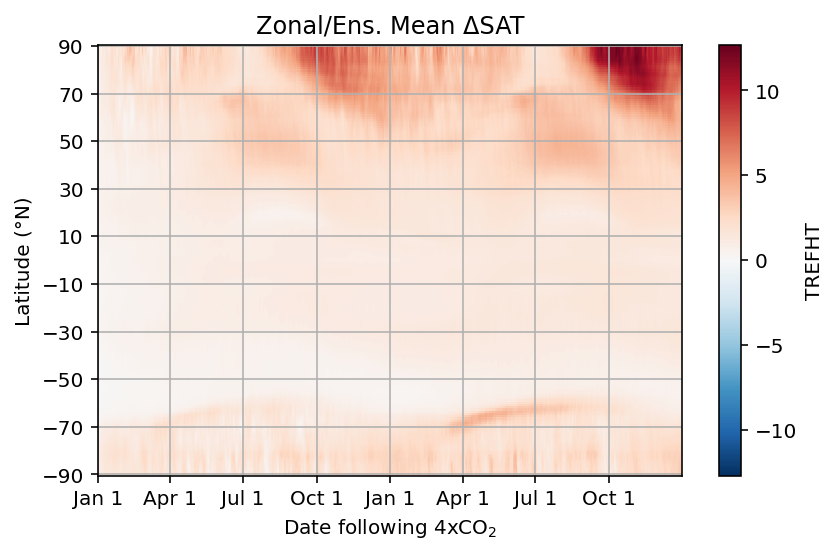

In [15]:
fig,ax = plt.subplots()
diff_jan_zonal.mean(dim='ens').plot(y='lat',ax=ax,cmap='RdBu_r')
ax.set_xticks(x_vals_jan)
ax.set_yticks(np.arange(-90,100,20))
ax.set_xticklabels(x_labs_jan)
ax.grid()
ax.set_ylabel('Latitude (°N)')
ax.set_xlabel('Date following 4xCO$_2$')
ax.set_title('Zonal/Ens. Mean ΔSAT')
plt.tight_layout()
plt.show()

In [16]:
# spatially average the differences
with ProgressBar():
    diff_jan_ant = spav(diff_jan,lat_bound_n=-70).compute()
    diff_jul_ant = spav(diff_jul,lat_bound_n=-70).compute()
# get t and p vals using 2 sample Welch's t-test
# note: one of the assumptions is that the samples are independent, which isn't strictly true
# because the Arctic area is part of the global average, but it makes up only 6% of the 
# Earth's surface area, so I do not feel like this is too large an issue

t_jan,p_jan = stats.ttest_ind(diff_jan_ant,diff_jan_glb,axis=0,equal_var=False,nan_policy='raise')
t_jul,p_jul = stats.ttest_ind(diff_jul_ant,diff_jul_glb,axis=0,equal_var=False,nan_policy='raise')

[########################################] | 100% Completed | 57.3s
[########################################] | 100% Completed | 28.8s


In [17]:
# Get some variables for relabeling the x-axes
first_days_jan = np.array([1,91,182,274])

x_vals_jan = np.concatenate((first_days_jan,first_days_jan+365))
x_labs_jan = np.tile(['Jan 1','Apr 1','Jul 1','Oct 1'],
                 (2))

first_days_jul = np.array([1,92,184,274])
x_vals_jul = np.concatenate((first_days_jul,first_days_jul+365))
x_labs_jul = np.tile(['Jul 1','Oct 1','Jan 1','Apr 1'],
                 (2))

xs=np.arange(1,731,1)

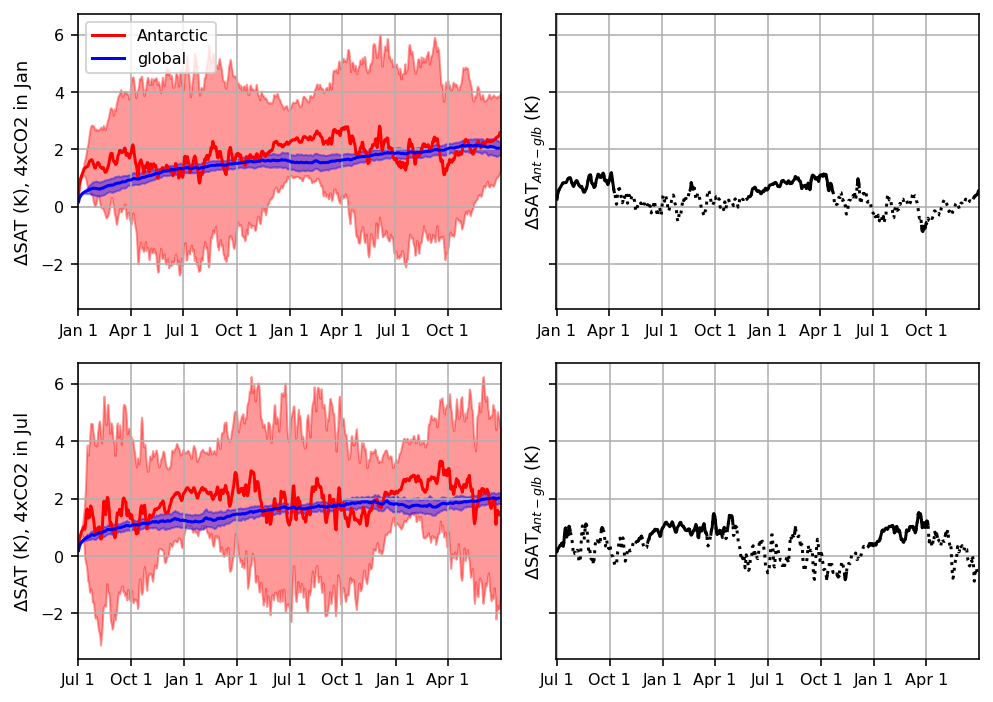

In [18]:
fig, axes = plt.subplots(ncols=2,nrows=2,sharey=True,figsize=(7,5))

for ax in axes.flatten():
    ax.grid()
    ax.set_xlim(0,730)
    ax.tick_params(axis='both',labelsize=8)

# top-left
axes[0,0].plot(xs,diff_jan_ant.mean(dim='ens'),color='red',label='Antarctic')
axes[0,0].fill_between(xs,diff_jan_ant.mean(dim='ens')-diff_jan_ant.std(dim='ens'),
                       diff_jan_ant.mean(dim='ens')+diff_jan_ant.std(dim='ens'),alpha=0.4,
                      color='red')

axes[0,0].plot(xs,diff_jan_glb.mean(dim='ens'),color='blue',label='global')
axes[0,0].fill_between(xs,diff_jan_glb.mean(dim='ens')-diff_jan_glb.std(dim='ens'),
                       diff_jan_glb.mean(dim='ens')+diff_jan_glb.std(dim='ens'),alpha=0.4,
                      color='blue')
axes[0,0].set_xticks(x_vals_jan)
axes[0,0].set_xticklabels(x_labs_jan)
axes[0,0].set_ylabel('ΔSAT (K), 4xCO2 in Jan',fontsize=9)
axes[0,0].legend(fontsize=8,loc='upper left')

# bottom-left
axes[1,0].plot(xs,diff_jul_ant.mean(dim='ens'),color='red',label='Antarctic')
axes[1,0].fill_between(xs,diff_jul_ant.mean(dim='ens')-diff_jul_ant.std(dim='ens'),
                       diff_jul_ant.mean(dim='ens')+diff_jul_ant.std(dim='ens'),alpha=0.4,
                      color='red')

axes[1,0].plot(xs,diff_jul_glb.mean(dim='ens'),color='blue',label='global')
axes[1,0].fill_between(xs,diff_jul_glb.mean(dim='ens')-diff_jul_glb.std(dim='ens'),
                       diff_jul_glb.mean(dim='ens')+diff_jul_glb.std(dim='ens'),alpha=0.4,
                      color='blue')
axes[1,0].set_xticks(x_vals_jul)
axes[1,0].set_xticklabels(x_labs_jul)
axes[1,0].set_ylabel('ΔSAT (K), 4xCO2 in Jul',fontsize=9)

# top-right
axes[0,1].plot(xs,(diff_jan_ant - diff_jan_glb).mean(dim='ens'),color='black',
               linestyle=':')
axes[0,1].plot(xs,((diff_jan_ant - diff_jan_glb).mean(dim='ens')).where(p_jan<0.05),color='black')

axes[0,1].set_xticks(x_vals_jan)
axes[0,1].set_xticklabels(x_labs_jan)

axes[0,1].set_ylabel('ΔSAT$_{Ant-glb}$ (K)',fontsize=9)

# bottom-right
axes[1,1].plot(xs,(diff_jul_ant - diff_jul_glb).mean(dim='ens'),color='black',
               linestyle=':')
axes[1,1].plot(xs,((diff_jul_ant - diff_jul_glb).mean(dim='ens')).where(p_jul<0.05),color='black')

axes[1,1].set_xticks(x_vals_jul)
axes[1,1].set_xticklabels(x_labs_jul)
axes[1,1].set_ylabel('ΔSAT$_{Ant-glb}$ (K)',fontsize=9)


plt.tight_layout()
plt.show()